# Importing and Ingesting Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import xgboost as xgb

 The Primary Land Use Tax Lot Output (PLUTO) dataset of housing of New York's boroughs cointains characteristics of the buildings in each borough of New York. This dataset will be used in our model. We will just import the borough with the most complaints, to reduce the size of the data set being handled. PLUTO database for the borough we will select later is going to be imported. To avoid having large datasets, as this is just a demo, we will not use all of the PLUTO data bases and we will only use the first 10,000 rows. This PLUTO database was processed before hand so loading it already conains only the fist 10,000 entries.

In [3]:
BX_df = pd.read_csv('BX_df.csv')

C:\Users\Santiago\anaconda3\envs\Pandas\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We will now download the data from the link given. Then the data will be read into a pandas DataFrame.The cell below is only needed to run if the DataFrame is not in the cloud storage object. We will work with two datasets, the first one contains all the complaints directed to the Department of Housing Preservation and Development of New York. To avoid running through the big dataset of the HPD you can jump to the cell before exploratory analysis.

In [ ]:
!wget -O hpd_df.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0720EN-SkillsNetwork/labs/Module%201/data/311_Service_Requests_from_2010_to_Present_min.csv
hpd_df = pd.read_csv('hpd_df.csv')

This DataFrame will be loaded into our cloud storage as a pickle (.pkl) file.

In [13]:
valid_ZC_BX = np.sum(np.invert(np.isnan(pd.unique(BX_df['ZipCode']))))
print('Valid Zip Codes in Bronx df:',valid_ZC_BX)

Valid Zip Codes in Bronx df: 11


# Data Wrangling

We will estimate how many reports have a missing incident address. Then we will find the most common complaint type so we can focus on those, because the idea is to help the Department of Housing Preservation and Develpment to tackle where there are the most amount of complaints. We will also drop all of the complaints that do not contain an address, because the idea is to use the address to link the properties of the housing to the number of complaints. To do this we will group the complaints dataset by it's address and then add a row of complaints to the PLUTO data set. Afterwards we will grab only the features we will look at from the PLUTO data set. Then add the a column with the number of complaints per address.

In [6]:
hpd_df['Incident Address'].isnull().sum()

52825

In [7]:
len(hpd_df['Complaint Type'].unique())

30

In [8]:
complaintsCounts = hpd_df['Complaint Type'].value_counts()
topComplaintsCounts = complaintsCounts[complaintsCounts > 900000]
print('The top complaint type:',complaintsCounts.index[0])

The top complaint type: HEAT/HOT WATER


In [9]:
topComplaints = hpd_df[hpd_df['Complaint Type'] == complaintsCounts.index[0]]
print('Number of Complaints including NaN\'s', topComplaints.shape[0])
topComplaints  = topComplaints.dropna(subset= ['Incident Address'])
print('Number of Complaints after dropping NaN\'s', topComplaints.shape[0])

Number of Complaints including NaN's 1261574
Number of Complaints after dropping NaN's 1261574


In [10]:
print('The borough with most complaints',topComplaints['Borough'].value_counts().index[0])
print('The borough with least complaints',topComplaints['Borough'].value_counts().index[-1])
print('The Zip Code with most complaints', topComplaints['Incident Zip'].value_counts().index[0])
print('The Adress with most complaints', topComplaints['Incident Address'].value_counts().index[0])
print('The ammouns of closed complaints',topComplaints['Closed Date'].notnull().sum())

The borough with most complaints BRONX
The borough with least complaints Unspecified
The Zip Code with most complaints 11226.0
The Adress with most complaints 89-21 ELMHURST AVENUE
The ammouns of closed complaints 1256876


In [29]:
topComplaintsBX = topComplaints[topComplaints['Borough'] == 'BRONX']
addressComplaintsBX = pd.DataFrame(topComplaintsBX['Incident Address'].value_counts())
addressComplaintsBX.rename({'Incident Address':'NumComplaints'},axis=1,inplace=True)
addressComplaintsBX[['Address']] = pd.DataFrame(addressComplaintsBX.index.to_series())
addressComplaintsBX.to_csv('addressComplaintsBX.csv',index = False)


Continue from here!!!

In [30]:
addressComplaintsBX = pd.read_csv('addressComplaintsBX.csv')
BX_df = BX_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]
X = pd.merge(left = BX_df, right = addressComplaintsBX, on = 'Address')

# Exploratory Data Analysis

Now, we will look at the correlation between the features and the number of complaints (NumComplaints). Then we will choose the top correlations and plot them in a scatter plot against the number of complaints to see what typo of correlation they have. 

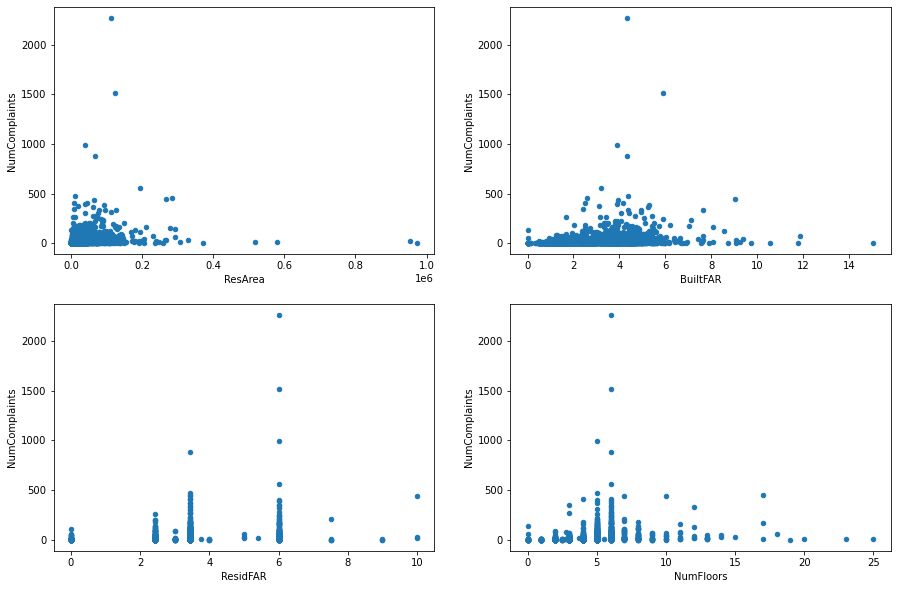

,NumComplaints
ResArea,0.214518
BuiltFAR,0.205106
ResidFAR,0.195383
NumFloors,0.192087


In [14]:
featuresCorr = X.corr()[['NumComplaints']].sort_values('NumComplaints', ascending = False).drop('NumComplaints')

features = featuresCorr.head(4).index.to_list()

%matplotlib inline
fig = plt.figure()
axList = []
for i, feat in enumerate(features):
    axList.append(fig.add_subplot(2,2,i+1))
    X.plot(kind='scatter', x = feat, y = 'NumComplaints', ax = axList[i], figsize = (15,10))

plt.show()
featuresCorr.head(4)    
    

# Model Development and Evaluation

It is clear from the scatter plots that there is no clear correlation between the features and the number of complaints. But for the sake of developing a model to predict the number of complaints, then a model will be trained to demonstrate how a linear model will be built and tested. On the other hand, a more realistic model will be built to predict the probability whether or not a house will generate a complaint.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
scoresLm = cross_val_score(lm, X[['NumFloors']],X[['NumComplaints']], cv=5)
print('The score for the Linear Model is :', scoresLm.mean())

The score for the Linear Model is : -0.0705830861687767


The model suggested by the course was one that predicts the number of complaints regarding the top complaint type in the Bronx. But, it is clear that it is not precise in any way. So the idea is to make a model that can predict the probability of a house in the bronx to generate a complaint of the top complaint type. As you will see this model can help predict which buildings will have a problem with their hot water.

In [32]:
def classify(x):
    if np.isnan(x):
        return 0
    else:
        return 1

Xlog = pd.merge(left = BX_df, right = addressComplaintsBX, how= 'left', on = 'Address', right_index = False)
Xlog['Complaint'] = Xlog.NumComplaints.apply(classify)
Xlog.drop(columns = 'NumComplaints', inplace = True)
Xlog.head()

,NumComplaints,Address
0,5220,1025 BOYNTON AVENUE
1,3615,2090 EAST TREMONT AVENUE
2,2462,2968 PERRY AVENUE
3,2277,2040 BRONXDALE AVENUE
4,2264,888 GRAND CONCOURSE


[0]	Train-logloss:0.385152	Test-logloss:0.385564
[1]	Train-logloss:0.351778	Test-logloss:0.361182
[2]	Train-logloss:0.339994	Test-logloss:0.359886
[3]	Train-logloss:0.334649	Test-logloss:0.361085
[4]	Train-logloss:0.326676	Test-logloss:0.363579
[5]	Train-logloss:0.318875	Test-logloss:0.365796
[6]	Train-logloss:0.314405	Test-logloss:0.363292
[7]	Train-logloss:0.308786	Test-logloss:0.367546
[8]	Train-logloss:0.305651	Test-logloss:0.365313
[9]	Train-logloss:0.301604	Test-logloss:0.366062


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

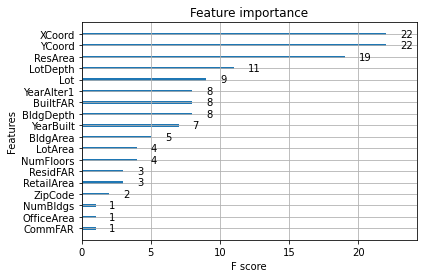

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(Xlog.drop(columns = ['Complaint','Address']),
                                                    Xlog[['Complaint']], test_size = 0.2, random_state=0)

dmTrain = xgb.DMatrix(x_train,label = y_train)
dmTest = xgb.DMatrix(x_test,label = y_test)

param = {'max_depth': 4, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric':'logloss'}
num_round = 10
xgbModel = xgb.train(param, dmTrain, num_round, evals=[(dmTrain, 'Train'),(dmTest, 'Test')])
xgb.plot_importance(xgbModel)

[0]	Train-logloss:0.375714	Test-logloss:0.386278
[1]	Train-logloss:0.339038	Test-logloss:0.362218
[2]	Train-logloss:0.324988	Test-logloss:0.359479
[3]	Train-logloss:0.318676	Test-logloss:0.361796
[4]	Train-logloss:0.31084	Test-logloss:0.364305
[5]	Train-logloss:0.305004	Test-logloss:0.367067
[6]	Train-logloss:0.294423	Test-logloss:0.368942
[7]	Train-logloss:0.290598	Test-logloss:0.369854
[8]	Train-logloss:0.286429	Test-logloss:0.368024
[9]	Train-logloss:0.281477	Test-logloss:0.371273


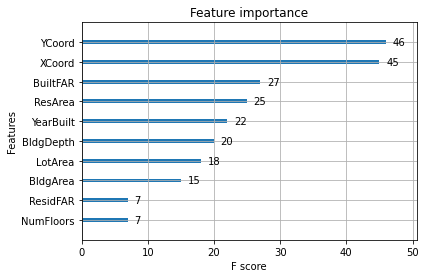

In [34]:
x_train, x_test, y_train, y_test = train_test_split(Xlog.drop(columns = ['Complaint','Address','ZipCode','Lot','YearAlter1','RetailArea',
                                                                         'LotDepth','NumBldgs','FacilFAR','CommFAR','OfficeArea']),
                                                    Xlog[['Complaint']], test_size = 0.2, random_state=0)

dmTrain = xgb.DMatrix(x_train,label = y_train)
dmTest = xgb.DMatrix(x_test,label = y_test)

param = {'max_depth': 5, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric':'logloss'}
num_round = 10
xgbModel = xgb.train(param, dmTrain, num_round, evals=[(dmTrain, 'Train'),(dmTest, 'Test')])
xgb.plot_importance(xgbModel)
plt.show()